In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd
import scipy
import time
import gurobipy as gp
from gurobipy import GRB

# E-MTAB-6362-raw-counts

Matrix of raw count data for ~25,000 genes in ~320 cells

In [2]:
data = pd.read_csv(r"..\New_data\E-MTAB-6362-raw-counts.csv", index_col="Unnamed: 0")
print(f"Size: {data.shape}")
data.head()

Size: (24826, 327)


,SAMEA104470620,SAMEA104470621,SAMEA104470622,SAMEA104470623,SAMEA104470624,SAMEA104470625,SAMEA104470626,SAMEA104470627,SAMEA104470628,SAMEA104470629,...,SAMEA104470946,SAMEA104470947,SAMEA104470948,SAMEA104470949,SAMEA104470950,SAMEA104470951,SAMEA104470952,SAMEA104470953,SAMEA104470954,SAMEA104470955
ENSMUSG00000000001,145.0,95.0,0.0,23.0,0.0,51.000000,145.00000,1.0,51.000000,1.0,...,303.00000,4.0,236.0,54.0,268.0,195.0,98.00000,174.0,247.0000,19.0
ENSMUSG00000000028,402.0,96.0,1.0,39.0,1.0,76.584206,170.10638,4.0,39.069515,0.0,...,487.00778,1.0,363.0,32.0,483.0,512.0,164.71356,299.0,864.0286,28.0
ENSMUSG00000000037,5.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,8.000000,0.0,...,174.00000,0.0,0.0,2.0,3.0,0.0,2.00000,0.0,14.0000,0.0
ENSMUSG00000000056,0.0,0.0,0.0,8.0,0.0,0.000000,16.00000,0.0,5.000000,0.0,...,42.00000,1.0,0.0,19.0,14.0,127.0,21.00000,31.0,69.0000,7.0
ENSMUSG00000000058,0.0,0.0,0.0,0.0,0.0,29.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0000,0.0


In [3]:
# select rows with mean above 1
data_2 = data.loc[data.mean(axis=1) > 1]
print(f"Size: {data_2.shape}")

Size: (14932, 327)


Text(0.5, 0, 'Zero values in row')

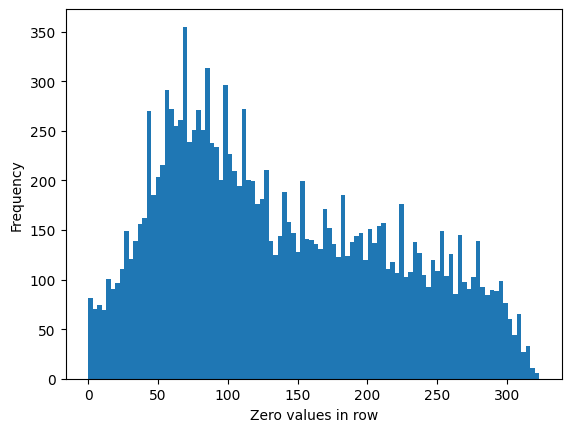

In [4]:
# find number of zero values per row (dropouts per gene)
num_missing = (data_2 == 0.0).sum(axis=1)
plt.hist(num_missing, bins=100);
plt.ylabel("Frequency")
plt.xlabel("Zero values in row")

In [5]:
((data_2 == 0.0).sum(axis=1) > 200).sum()

3827

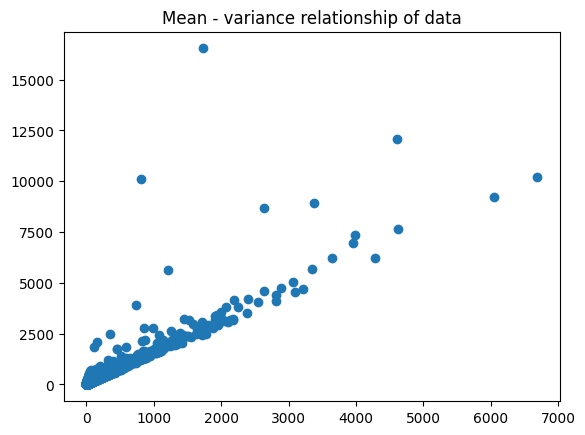

In [6]:
plt.scatter(data.mean(axis=1), data.std(axis=1))
plt.title("Mean - variance relationship of data")
plt.show()

(array([261.,  47.,  11.,   4.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([   0.    ,  340.0163,  680.0326, 1020.0489, 1360.0652, 1700.0815,
        2040.0978, 2380.1141, 2720.1304, 3060.1467, 3400.163 ]),
 <BarContainer object of 10 artists>)

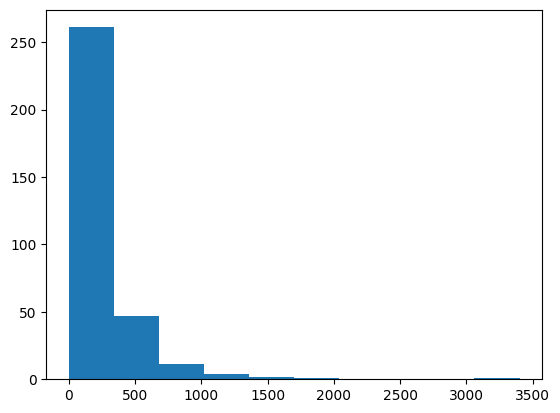

In [7]:
plt.hist(data_2.iloc[2000])

In [8]:
data_norm = pd.read_csv(r"..\New_data\E-MTAB-6362-normalised-counts.csv", index_col="Unnamed: 0")
print(f"Size: {data_norm.shape}")
data_norm.head()

Size: (24826, 327)


,SAMEA104470620,SAMEA104470621,SAMEA104470622,SAMEA104470623,SAMEA104470624,SAMEA104470625,SAMEA104470626,SAMEA104470627,SAMEA104470628,SAMEA104470629,...,SAMEA104470946,SAMEA104470947,SAMEA104470948,SAMEA104470949,SAMEA104470950,SAMEA104470951,SAMEA104470952,SAMEA104470953,SAMEA104470954,SAMEA104470955
ENSMUSG00000000001,47.002956,80.39816,0.00000,75.185520,0.00000,29.291403,76.253555,45.021896,85.668640,127.16174,...,42.430270,61.325233,76.17223,35.086468,61.029556,46.34809,67.234100,77.131165,29.981830,73.650260
ENSMUSG00000000028,130.311650,81.24446,328.83917,127.488480,101.57752,43.985466,89.456665,180.087590,65.628080,0.00000,...,68.197600,15.331308,117.16323,20.791980,109.989840,121.69345,113.003750,132.541470,104.879190,108.537230
ENSMUSG00000000037,1.620792,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,13.438218,0.00000,...,24.365898,0.000000,0.00000,1.299499,0.683167,0.00000,1.372124,0.000000,1.699375,0.000000
ENSMUSG00000000056,0.000000,0.00000,0.00000,26.151484,0.00000,0.000000,8.414186,0.000000,8.398887,0.00000,...,5.881424,15.331308,0.00000,12.345239,3.188111,30.18568,14.407307,13.741759,8.375491,27.134308
ENSMUSG00000000058,0.000000,0.00000,0.00000,0.000000,0.00000,16.655895,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


# Functions

## Bootstrap

Rounds counts to nearest integers

Assumes no missing values (can deal with them)

In [9]:
def bootstrap_data_optim(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """
    # change to series
    # samples = pd.Series(samples)

    # drop missing values
    # if drop_missing:
    #    samples = samples.dropna()
    # replace with 0
    # else:
    #    samples = samples.fillna(value=0.0)

    # change to int
    samples = samples.astype('int64')
    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    if printing or plot:
        for x in range(x_max + 1):
            if printing:
                print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
            if plot:
                plt.hist(counts[:, x] / n)
                plt.title(f"Hist of p({x})")
                plt.axvline(intervals[x][0], color="red")
                plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

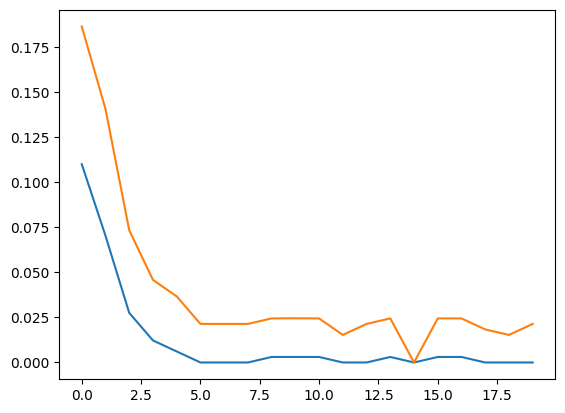

In [13]:
# select a sample from a gene (row of the dataset)
test_sample = data_2.iloc[0]

# bootstrap
test_intervals = bootstrap_data_optim(samples=test_sample, N=1000, plot=False, printing=False)

# plot first 10 resulting bounds
lb = [t_int[0] for t_int in test_intervals]
ub = [t_int[1] for t_int in test_intervals]
plt.plot(lb[:20])
plt.plot(ub[:20])

## LP bursty solver

In [14]:
def bursty_LP_optim(N, intervals, k0=None, k1=None, M=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    N: number of rows of Q / number of equations used
    M: maximum burst size to consider (>= 1)
    intervals: confidence intervals for at least N + 1 states

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # if max burst not specified: set to the largest burst that appears in Qp = 0 constraint
    if not M:
        M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # Construct the problem

    # Variables: specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable()
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    c = cv.Parameter(M)
    objective = c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


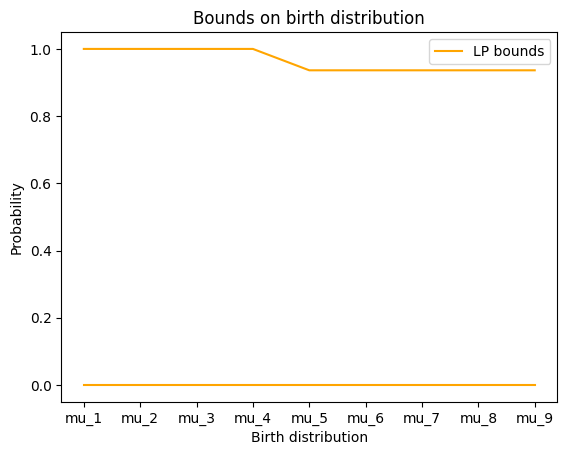

In [15]:
# solve
N = 10
M = N - 1
test_bounds = bursty_LP_optim(N, test_intervals, k0=1)

# extract and plot bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower_LP = [test_bounds[var][0] for var in labels]
upper_LP = [test_bounds[var][1] for var in labels]
plt.plot(labels, upper_LP, label = "LP bounds", color="orange")
plt.plot(labels, lower_LP, color="orange")
plt.title("Bounds on birth distribution")
plt.ylabel("Probability")
plt.xlabel("Birth distribution")
plt.legend()
plt.show()

## NLP bursty solver

In [16]:
def bursty_NLP(N, intervals, k0=None, k1=None, K=10, printing=False):
    """
    Solve bursty NLP system to get bounds on parameters

    Inputs:
    N: number of rows of Q / number of equations used
    intervals: CI's on at least N + 1 states
    k0: (optional) value of k0
    k1: (optional) value of k1
    K: prescribed max on kr variables in optimization (for computation)
    printing: whether to print solution information
    """
    # largest burst 1 less than N
    M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]
    
    # create model
    model = gp.Model("burst")

    # set options
    if not printing:
        model.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = model.addMVar(shape=N + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
    pis = model.addMVar(shape=M, vtype=GRB.CONTINUOUS, name="pis", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if not k0:
        k0 = model.addVar(vtype=GRB.CONTINUOUS, name="k0", lb=0, ub=K)
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = model.addVar(vtype=GRB.CONTINUOUS, name="k1", lb=0, ub=K)
        k1_var = True
    else:
        k0_var = False

    # Constraints:
    # Stationary condition: Qp = 0
    model.addConstr(k1*(Q1 @ p) + k0*(Q00 @ p) + gp.quicksum([k0*pis[m]*(Q0(m + 1) @ p) for m in range(0, M)]) == 0, name="Qp=0")
    # bounds
    model.addConstr(pl <= p, name="lb")
    model.addConstr(p <= pu, name="ub")
    # distributions
    model.addConstr(p.sum() <= 1, name="pdist")
    model.addConstr(pis.sum() <= 1, name="pidist")

    # solution dictionary
    solutions = {}

    # optimize for each variable in turn
    if k0_var:
        # minimize
        model.setObjective(k0, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k0'] = [min_val, max_val]
    else:
        solutions['k0'] = [k0]
    
    if k1_var:
        # minimize
        model.setObjective(k1, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k1'] = [min_val, max_val]
    else:
        solutions['k1'] = [k1]

    for m in range(0, M):
        # minimize
        model.setObjective(pis[m], GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(pis[m], GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions[f'mu_{m + 1}'] = [min_val, max_val]

    return solutions

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-10


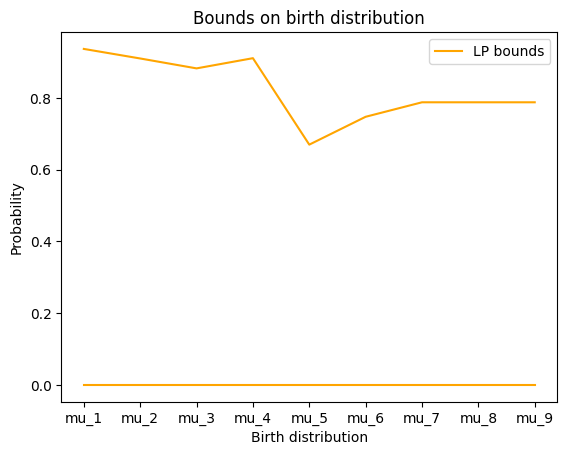

In [17]:
# solve 
N = 10
M = N - 1
test_bounds = bursty_NLP(N, test_intervals, k0=1)

# extract and plot bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower_NLP = [test_bounds[var][0] for var in labels]
upper_NLP = [test_bounds[var][1] for var in labels]
plt.plot(labels, upper_NLP, label = "LP bounds", color="orange")
plt.plot(labels, lower_NLP, color="orange")
plt.title("Bounds on birth distribution")
plt.ylabel("Probability")
plt.xlabel("Birth distribution")
plt.legend()
plt.show()

## Pipeline

- choose state space truncation
- solve LP and NLP

In [22]:
def bound_sample_refined(sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True):
    """
    Given transcript samples from gene, bootstrap and solve LP to bound parameters

    sample: list of counts of transcripts of gene in cells
    threshold: minimum number of occurances in sample needed to include state x
            set to zero to use up to max state available
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    N: option to manually specify number of equations used
    settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution
    """

    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)

    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    # find max state with more than threshold occurances
    x_max_thresh = x_max
    # look at all states: decreasing from max
    for x in range(x_max, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2

    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
     
    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max, color="red", label=f"Max state {x_max}")
        plt.axvline(x_max_thresh, color="red", label=f"Max threshold state {x_max_thresh}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()

    # get bounds on p(0), ..., p(x_max_thresh)
    # can use UP TO equation N = x_max, as involves up to p(x_max_thresh)
    # equation N involves pi's up to pi_(N-1), so M = N - 1
    if not N:
        N = x_max_thresh
    M = N - 1

    # solve LP using data
    if NLP:
        s = time.time()
        solutions_dist_NLP = bursty_NLP(N, intervals, k0=1, K=K, printing=False)
        print(f"NLP: {time.time() - s}")
    if LP:
        s = time.time()
        solutions_dist_LP = bursty_LP_optim(N, intervals, k0=1)
        e = time.time()
        print(f"LP: {e - s}")

    '''
    # check if infeasible
    while solutions_dist_NLP['mu_1'][0] is None:
        if print_status: print(f"N = {N} NLP infeasible")
        # stop if too few equations (cannot reduce any further leads to M = 0)
        if N <= skip + 1:
            break
        # try again with smaller N (drop 'skip' # of equations)
        N -= skip
        M -= skip
        solutions_dist_NLP = bursty_NLP(N, intervals, k0=1, K=K, printing=False)

    if print_status: print(f"N = {N} NLP feasible:")
    '''

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower_NLP = [solutions_dist_NLP[var][0] for var in labels]
        upper_NLP = [solutions_dist_NLP[var][1] for var in labels]
        lower_LP = [solutions_dist_LP[var][0] for var in labels]
        upper_LP = [solutions_dist_LP[var][1] for var in labels]
        plt.plot(labels, upper_LP, label = "LP bounds", color="orange")
        plt.plot(labels, lower_LP, color="orange")
        plt.scatter(labels, upper_LP, color="orange")
        plt.scatter(labels, lower_LP, color="orange")
        plt.plot(labels, upper_NLP, label = "NLP bounds", color="blue")
        plt.plot(labels, lower_NLP, color="blue")
        plt.scatter(labels, upper_NLP, color="blue")
        plt.scatter(labels, lower_NLP, color="blue")
        plt.title("Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist_NLP, solutions_dist_LP

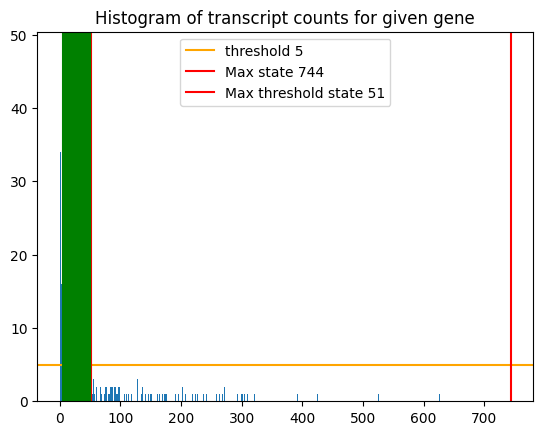

NLP: 292.3000831604004


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 13.490131139755249


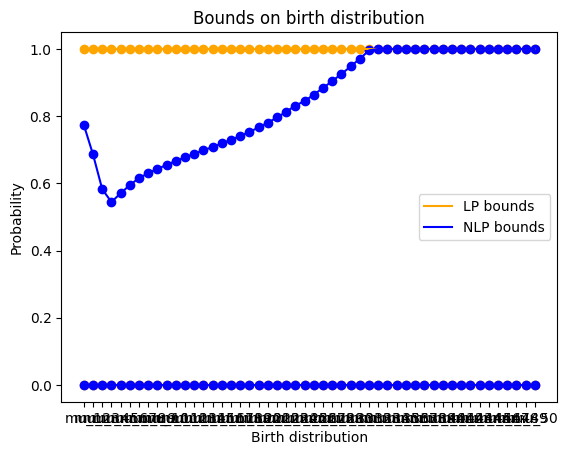

In [23]:
test_sample = data_2.iloc[0]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

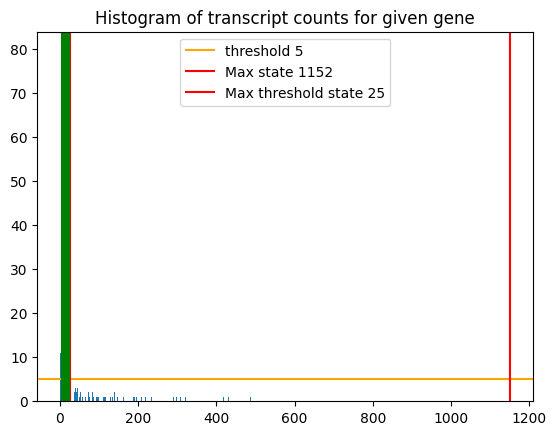

NLP: 23.980733633041382


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.2919201850891113


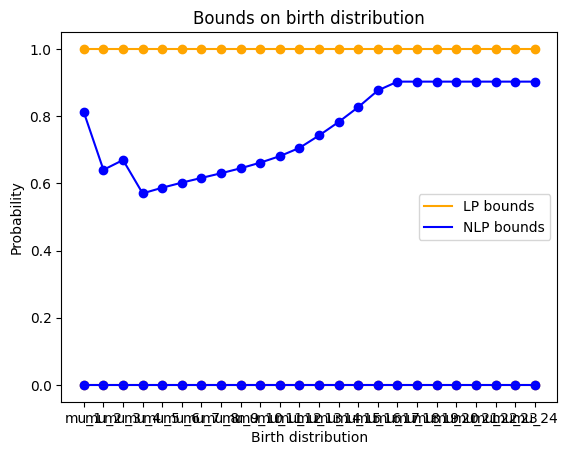

In [24]:
test_sample = data_2.iloc[1]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

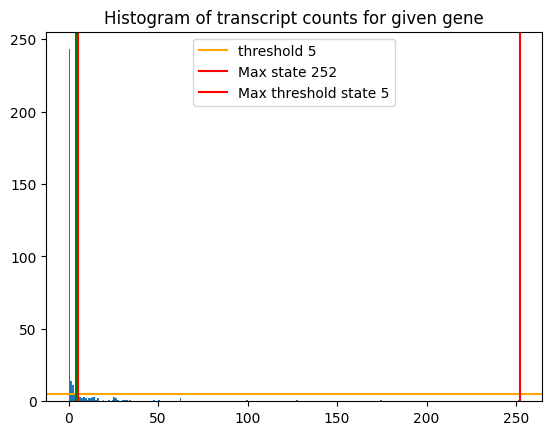

NLP: 0.017930984497070312
LP: 0.15971994400024414


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


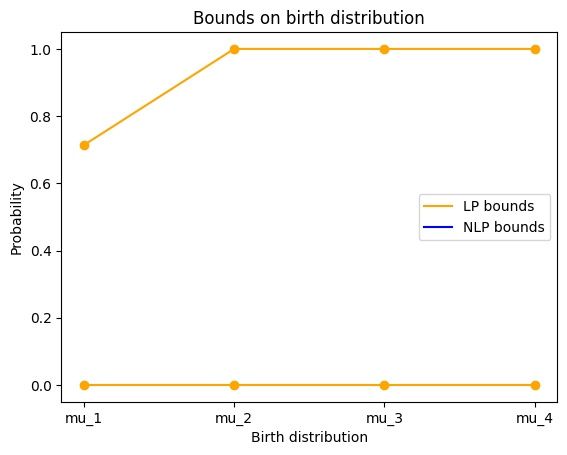

In [25]:
test_sample = data_2.iloc[2]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

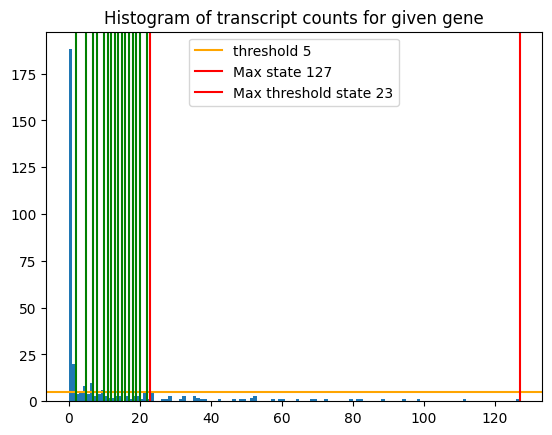

NLP: 16.286618947982788


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.9839468002319336


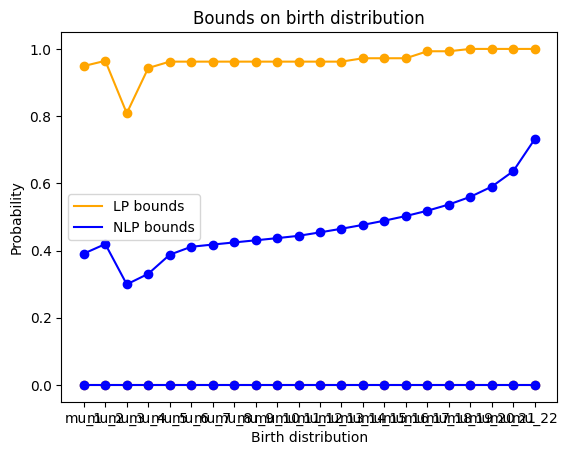

In [26]:
test_sample = data_2.iloc[3]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Edge case


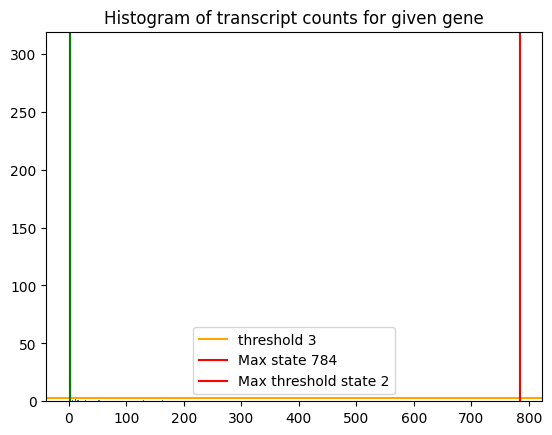

NLP: 0.0069773197174072266
LP: 0.04298567771911621


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


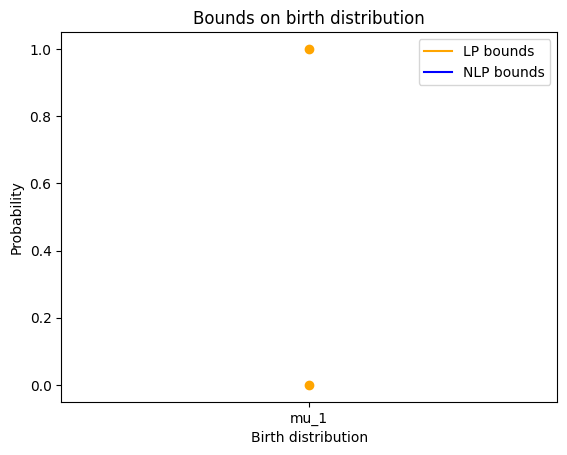

In [30]:
test_sample = data_2.iloc[4]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

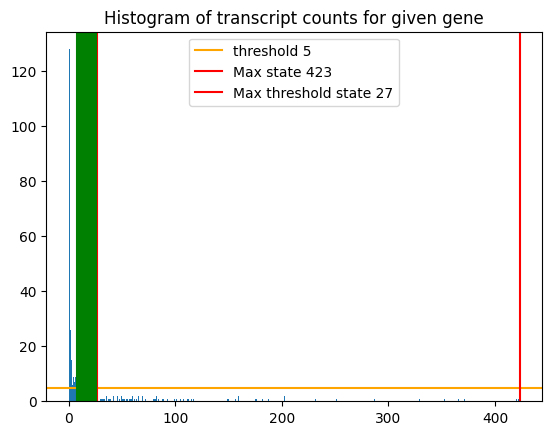

NLP: 1.3440451622009277


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.4098560810089111


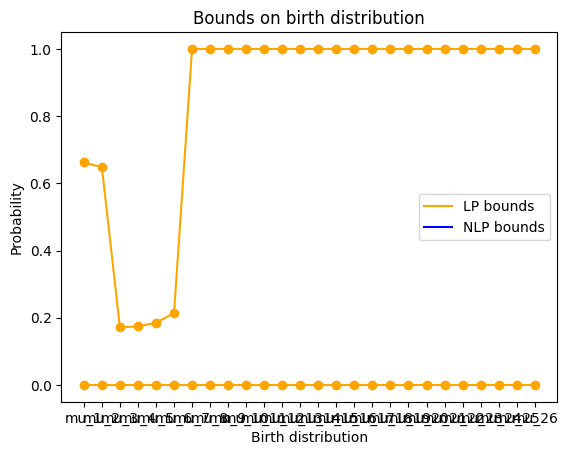

In [31]:
test_sample = data_2.iloc[5]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

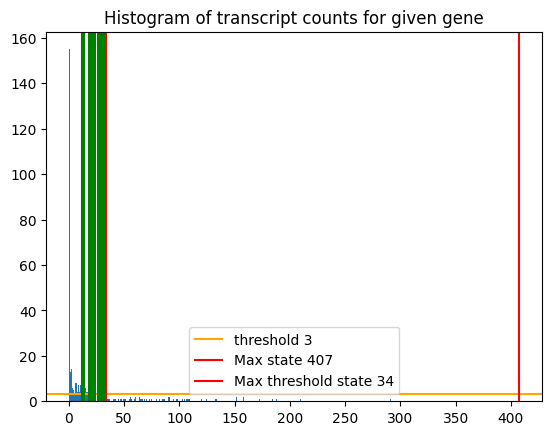

NLP: 38.85932636260986


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.95046329498291


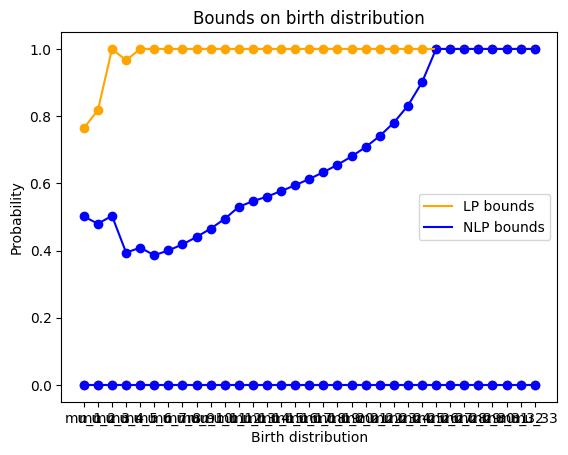

In [35]:
test_sample = data_2.iloc[6]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Gene 11595
Edge case


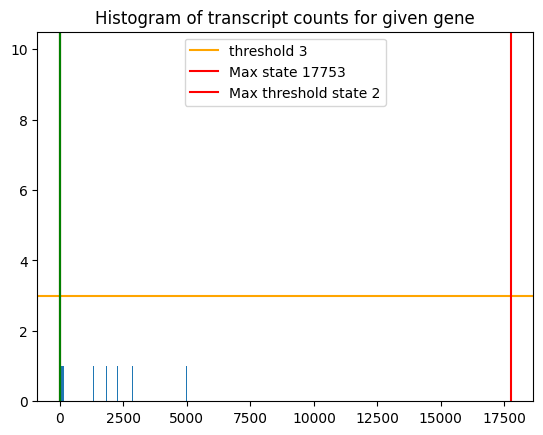

NLP: 0.12615680694580078
LP: 0.05749702453613281


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


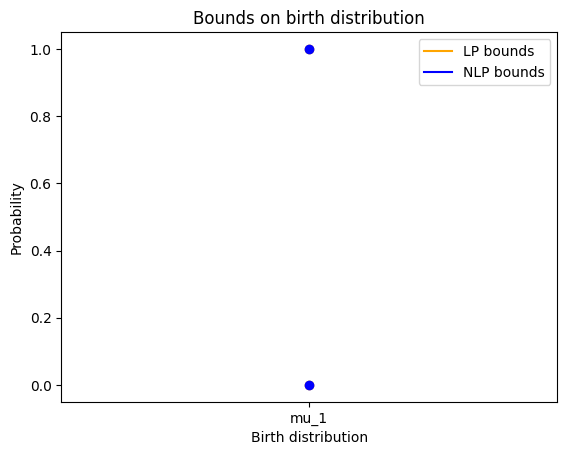

In [37]:
rng = np.random.default_rng(10)
idx = rng.choice(data_2.shape[0], 1)[0]
print(f"Gene {idx}")
test_sample = data_2.iloc[idx]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Gene 1578


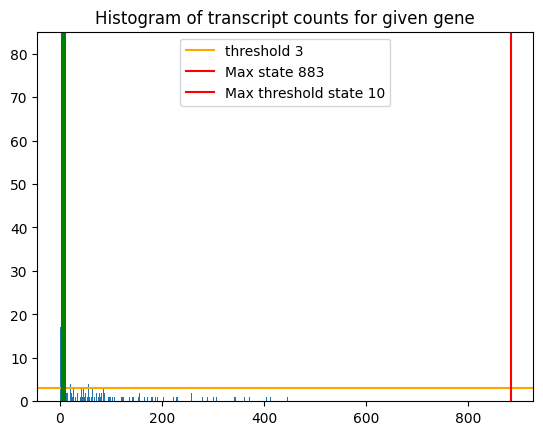

NLP: 0.4359264373779297
LP: 0.15657424926757812


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


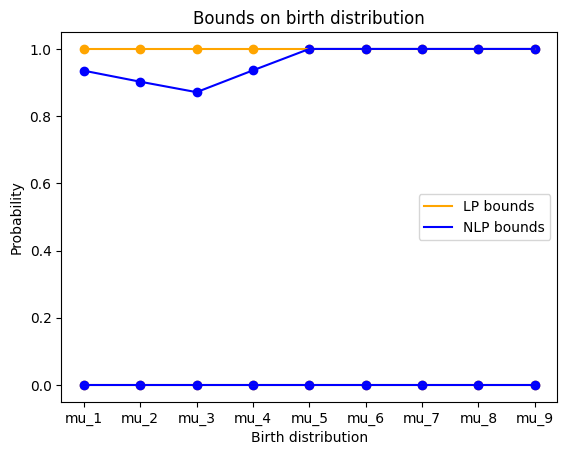

In [42]:
rng = np.random.default_rng(30)
idx = rng.choice(data_2.shape[0], 1)[0]
print(f"Gene {idx}")
test_sample = data_2.iloc[idx]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)